In [1]:
%matplotlib inline
%load_ext autotime
%load_ext snakeviz
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import datetime as dt
from SIR_models import *
import datetime as dt

# Modelling the COVID spread with a SIR model


$$\frac{dS}{dt} = -\beta IS$$

$$\frac{dI}{dt} = \beta IS-\gamma I$$

$$\frac{dR}{dt} = \gamma I$$

Beta:0.2570546304771033 Gamma:0.01392397954624887
R0:18.46129043951045
Predicting with Beta:0.2570546304771033 Beta2: 0.2570546304771033 Gamma:0.01392397954624887


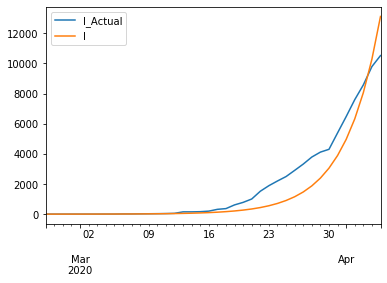

time: 1.39 s


In [2]:
#%%snakeviz ## BETA3
trained = SIR('Brazil', N=200e6,alpha=0.7)
#out = jap.train()
#jap.estimate()
out = trained.train()
#out = Trained.predict(beta=0.20,gamma=0.07)
trained.I_fit_plot()

Beta:0.3118208370835003 Beta2: 0.22692566039991727 Gamma:0.02291680908459917
R0:13.606642876518697
Predicting with Beta:0.3118208370835003 Beta2: 0.22692566039991727 Gamma:0.02291680908459917


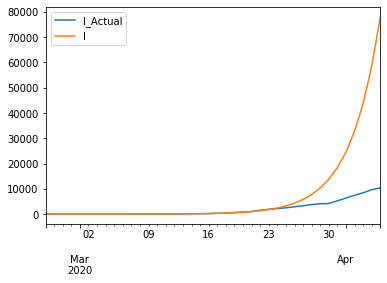

time: 2.49 s


In [3]:
#%%snakeviz ## BETA3
#custom = SIR.Learner('Brazil', N=200e6,alpha=0.7,forcedBeta=0.3)
#custom = SIR.Learner('Brazil', N=200e6,alpha=0.7,forcedGamma=0.07)
#custom = SIR.Learner('Brazil', N=200e6,alpha=0.7,forcedBeta = 0.20,forcedGamma=0.07, daysPredict = 30,nth=1)
custom = SIR('Brazil', N=200e6, alpha=0.7, forcedGamma=0.07, daysPredict=30, 
                     nth=1, estimateBeta2=True, quarantineDate=dt.datetime(2020,3,15))
custom = SIR('Brazil', N=200e6, alpha=0.7, daysPredict=30, 
                     nth=1, estimateBeta2=True, recoveredAssumption = 2, quarantineDate=dt.datetime(2020,3,15))

#out = jap.train()
#jap.estimate()
out = custom.train()
#out = custom.predict(beta=0.20,gamma=0.07)
#out = custom.predict(beta=0.20,gamma=None)
custom.I_fit_plot()

In [4]:
0.16/0.01

16.0

Error in callback <function LineWatcher.stop at 0x0000018BC9DF0C18> (for post_run_cell):


AssertionError: 

In [5]:
nonl = custom.df
nonl

,I_Actual,R_Actual,S,I,R,H
2020-02-26,1.0,0.0,2.000000e+08,1.000000e+00,0.000000e+00,NaN
2020-02-27,1.0,0.0,2.000000e+08,1.334981e+00,2.657180e-02,NaN
2020-02-28,1.0,0.0,2.000000e+08,1.782128e+00,6.204093e-02,NaN
2020-02-29,2.0,0.0,2.000000e+08,2.379076e+00,1.093928e-01,NaN
2020-03-01,2.0,0.0,2.000000e+08,3.176290e+00,1.726304e-01,NaN
...,...,...,...,...,...,...
2020-08-28,NaN,NaN,2.107385e+04,1.532217e+07,1.846568e+08,600.479256
2020-08-29,NaN,NaN,2.071480e+04,1.497538e+07,1.850039e+08,575.206685
2020-08-30,NaN,NaN,2.036977e+04,1.463644e+07,1.853432e+08,551.172785
2020-08-31,NaN,NaN,2.003808e+04,1.430517e+07,1.856748e+08,528.249761


time: 24.4 ms


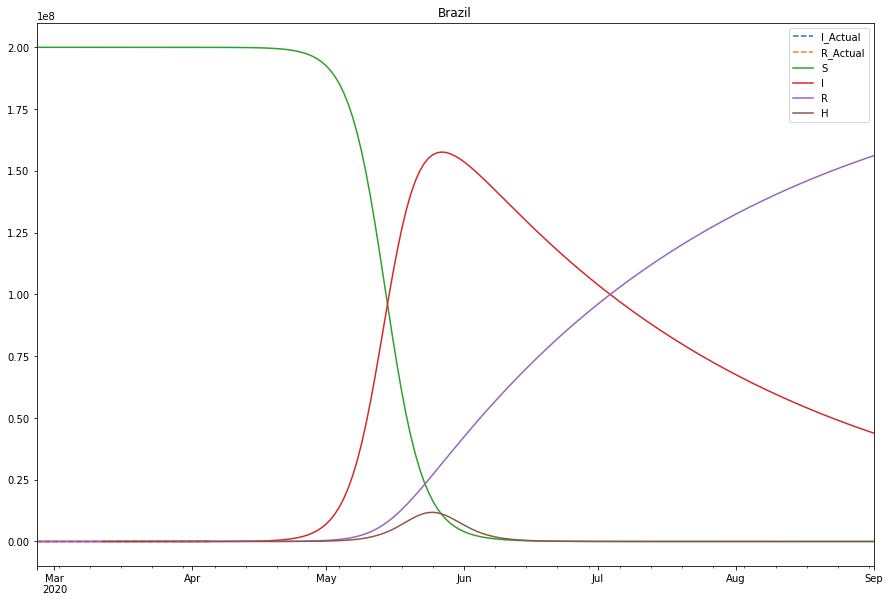

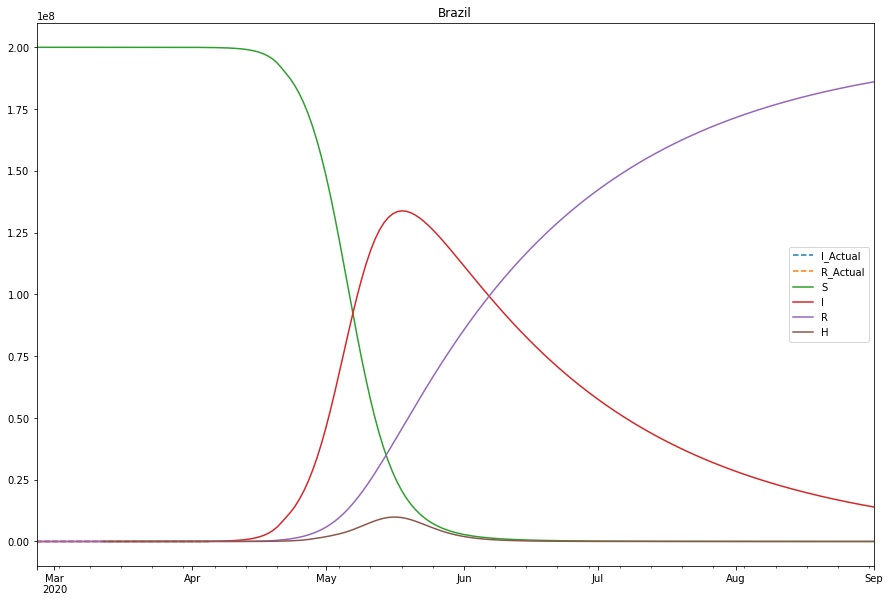

time: 654 ms


In [6]:
trained.main_plot()
custom.main_plot()

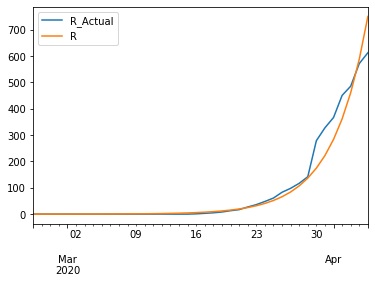

time: 230 ms


In [7]:
trained.R_fit_plot()

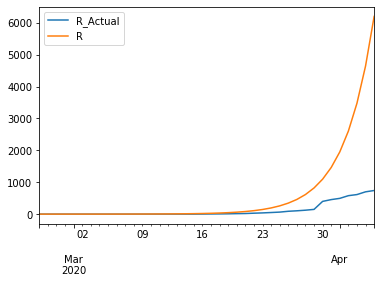

time: 230 ms


In [8]:
custom.R_fit_plot()

# Sensitivity Analysis

## Sensitivity to nth

In [9]:
t1 = SIR('Brazil', N=200e6, alpha=0.7)
t1.train()

Beta:0.2570546304771033 Gamma:0.01392397954624887
R0:18.46129043951045
Predicting with Beta:0.2570546304771033 Beta2: 0.2570546304771033 Gamma:0.01392397954624887
time: 488 ms


In [10]:
t2 = SIR('Brazil', N=200e6, alpha=0.7, nth=100)
t2.train()

Beta:0.1908730646583514 Gamma:1e-08
R0:19087306.46583514
Predicting with Beta:0.1908730646583514 Beta2: 0.1908730646583514 Gamma:1e-08
time: 359 ms


In [11]:
t2 = SIR('Brazil', N=200e6, alpha=0.7, nth=150)
t2.train()

Beta:0.1908730646583514 Gamma:1e-08
R0:19087306.46583514
Predicting with Beta:0.1908730646583514 Beta2: 0.1908730646583514 Gamma:1e-08
time: 370 ms


In [12]:
t2 = SIR('Brazil', N=200e6, alpha=0.7, nth=1000)
t2.train()

Beta:0.1728469813767866 Gamma:0.0102471265562016
R0:16.86784879924987
Predicting with Beta:0.1728469813767866 Beta2: 0.1728469813767866 Gamma:0.0102471265562016
time: 334 ms


## Sensitivity to infected assumption

In [13]:
t1 = SIR('Brazil', N=200e6, alpha=0.7, infectedAssumption=1)
t1.train()

Beta:0.2570546304771033 Gamma:0.01392397954624887
R0:18.46129043951045
Predicting with Beta:0.2570546304771033 Beta2: 0.2570546304771033 Gamma:0.01392397954624887
time: 671 ms


In [14]:
t1 = SIR('Brazil', N=200e6, alpha=0.7, infectedAssumption=2)
t1.train()

Beta:0.2437433160792515 Gamma:1e-08
R0:24374331.60792515
Predicting with Beta:0.2437433160792515 Beta2: 0.2437433160792515 Gamma:1e-08
time: 694 ms


In [15]:
t1 = SIR('Brazil', N=200e6, alpha=0.7, infectedAssumption=3)
t1.train()

Beta:0.24392697388582954 Gamma:1e-08
R0:24392697.388582952
Predicting with Beta:0.24392697388582954 Beta2: 0.24392697388582954 Gamma:1e-08
time: 333 ms


In [16]:
t1 = SIR('Brazil', N=200e6, alpha=0.7, infectedAssumption=4)
t1.train()

Beta:0.24986970067634118 Gamma:0.005898840090945374
R0:42.35912430646954
Predicting with Beta:0.24986970067634118 Beta2: 0.24986970067634118 Gamma:0.005898840090945374
time: 550 ms


## Sensitivity to population

In [11]:
t1 = SIR('Brazil', N=200e6, alpha=0.7,)
t1.train()

Beta:0.24335959837325014 Gamma:0.018210678493576306
R0:13.363565693562357
Predicting with Beta:0.24335959837325014 Beta2: 0.24335959837325014 Gamma:0.018210678493576306
time: 381 ms


In [12]:
t1 = SIR('Brazil', N=150e6, alpha=0.7,)
t1.train()

Beta:0.24005201741333823 Gamma:0.0146919686968428
R0:16.338995975734942
Predicting with Beta:0.24005201741333823 Beta2: 0.24005201741333823 Gamma:0.0146919686968428
time: 413 ms


In [13]:
t1 = SIR('Brazil', N=100e6, alpha=0.7,)
t1.train()

Beta:0.24005276781364476 Gamma:0.014690791071094188
R0:16.340356802567022
Predicting with Beta:0.24005276781364476 Beta2: 0.24005276781364476 Gamma:0.014690791071094188
time: 482 ms


In [14]:
t1 = SIR('Brazil', N=50e6, alpha=0.7,)
t1.train()

Beta:0.24005784581317516 Gamma:0.014690099207219233
R0:16.34147206406899
Predicting with Beta:0.24005784581317516 Beta2: 0.24005784581317516 Gamma:0.014690099207219233
time: 422 ms


In [15]:
t1 = SIR('Brazil', N=1e6, alpha=0.7,)
t1.train()

Beta:0.24055436749870834 Gamma:0.014615206043082665
R0:16.459184139423204
Predicting with Beta:0.24055436749870834 Beta2: 0.24055436749870834 Gamma:0.014615206043082665
time: 262 ms


In [16]:
t1 = SIR('Brazil', N=0.5e6, alpha=0.7,)
t1.train()

Beta:0.24107014619385436 Gamma:0.014537032977569744
R0:16.583173923167074
Predicting with Beta:0.24107014619385436 Beta2: 0.24107014619385436 Gamma:0.014537032977569744
time: 344 ms


# SEIR Comparison

Beta:0.2570546304771033 Gamma:0.01392397954624887
R0:18.46129043951045
Predicting with Beta:0.2570546304771033 Beta2: 0.2570546304771033 Gamma:0.01392397954624887


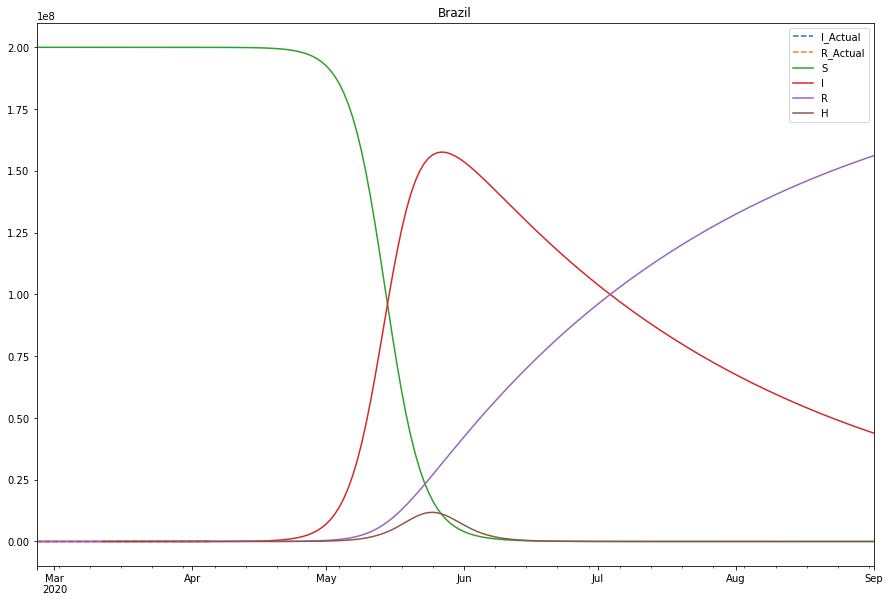

time: 1.4 s


In [23]:
seir = SIR('Brazil', N=200e6, alpha=0.7)
seir.train()
seir.main_plot()

Beta:0.3115537079741299 Gamma:0.07 Sigma:0.39634384352058694
R0:4.450767256773283
Predicting with Beta:0.3115537079741299 Beta2: 0.3115537079741299 Gamma:0.07 Sigma:0.39634384352058694


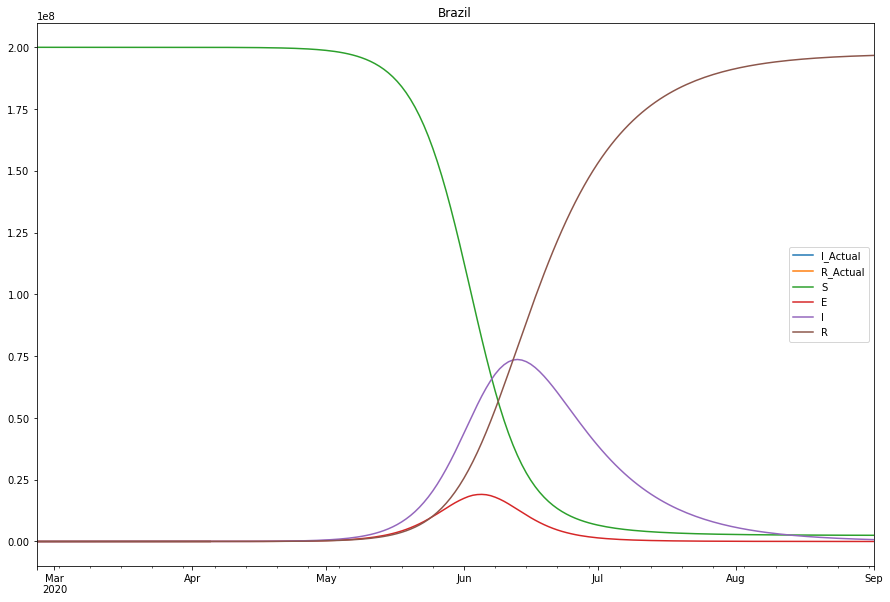

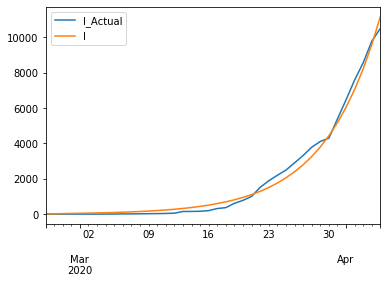

time: 4.82 s


In [24]:
seir = LearnerSEIR('Brazil', N=200e6, alpha=0.7, elag=15, forcedGamma = 0.07)
seir.train()
seir.main_plot()
seir.I_fit_plot()

## Constrained optimization - SEIR

* Tentar colocar os confirmados uma parte no incubados
* tentar falar que 1/3 dos confirmados tao incubados (ou alguma premissa) - talvez nao pq aqui mal estao testando
* calibrar o período de incubação

WHO:
>The “incubation period” means the time between catching the virus and beginning to have symptoms of the disease. Most estimates of the incubation period for COVID-19 range from 1-14 days, most commonly around five days. These estimates will be updated as more data become available. So from 5 to 7.Or 6 if 5 is common. (Inverse of sigma)

Beta:1.097299653257514 Gamma:0.03484764527227411
R0:31.488487806966987
Predicting with Beta:1.097299653257514 Beta2: 1.097299653257514 Gamma:0.03484764527227411 Sigma:0.08333333333333333


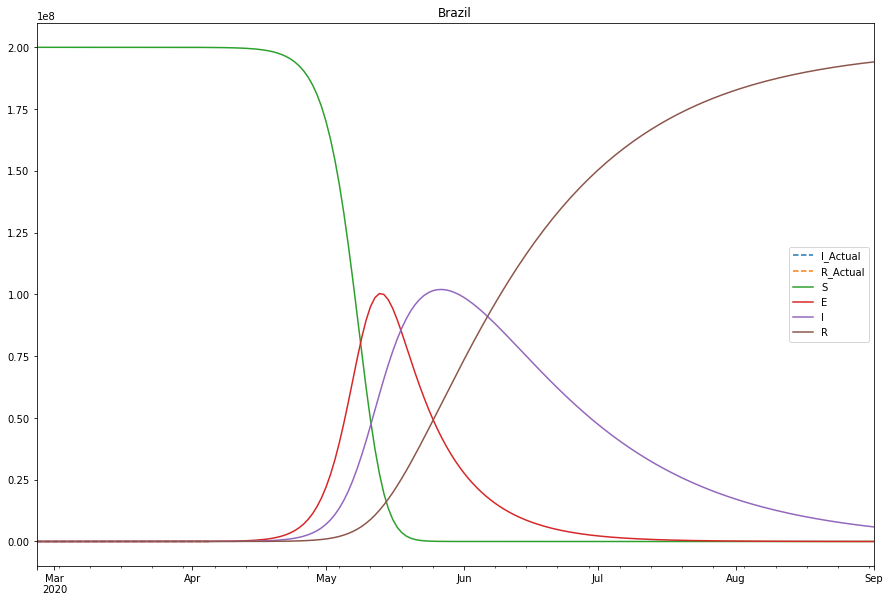

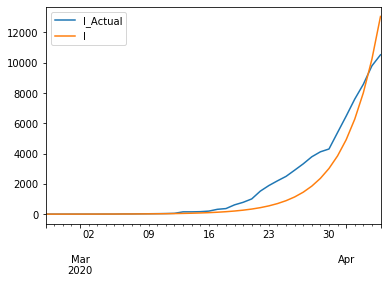

time: 1.17 s


In [25]:
t1 = SEIR(
    country='Brazil', 
    N=200e6, 
    alpha=.9,
#    betaBounds = (0.0001, 0.4),
#    gammaBounds = (0.01, 0.1),
    betaBounds = (0.0001, 2.0),
    gammaBounds = (0.0001, 2.0),
    incubationPeriod=12,
    forceE0 = 0,
         )
t1.train()
t1.main_plot()
t1.I_fit_plot()

Beta:0.4 Gamma:0.01
R0:40.0
Predicting with Beta:0.4 Beta2: 0.4 Gamma:0.01 Sigma:0.08333333333333333


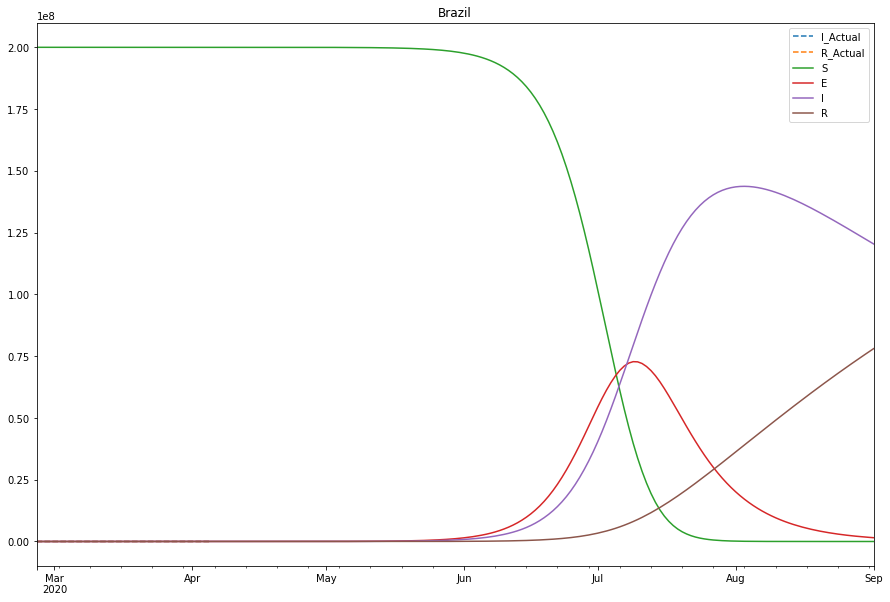

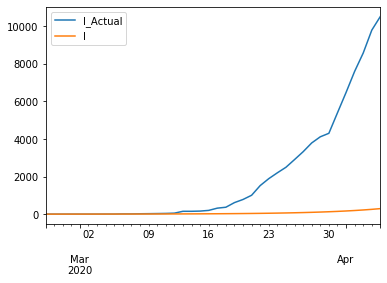

time: 1.05 s


In [26]:
t1 = SEIR(
    country='Brazil', 
    N=200e6, 
    alpha=.9,
    betaBounds = (0.1, 0.4),
    gammaBounds = (0.01, 0.1),
    incubationPeriod=12,
    forceE0 = 0,
         )
t1.train()
t1.main_plot()
t1.I_fit_plot()

# A study on Korea's beta

In [27]:
fraction_pop = (9+45)/2/230
fraction_pop

0.11739130434782609

time: 4 ms


Beta:0.4095119265319684 Gamma:0.057912832590347366
R0:7.071177633957139
Predicting with Beta:0.4095119265319684 Beta2: 0.4095119265319684 Gamma:0.057912832590347366

Max:
8728.668625248987
Est:
1309.300293787348
H Max:
785.019673878802


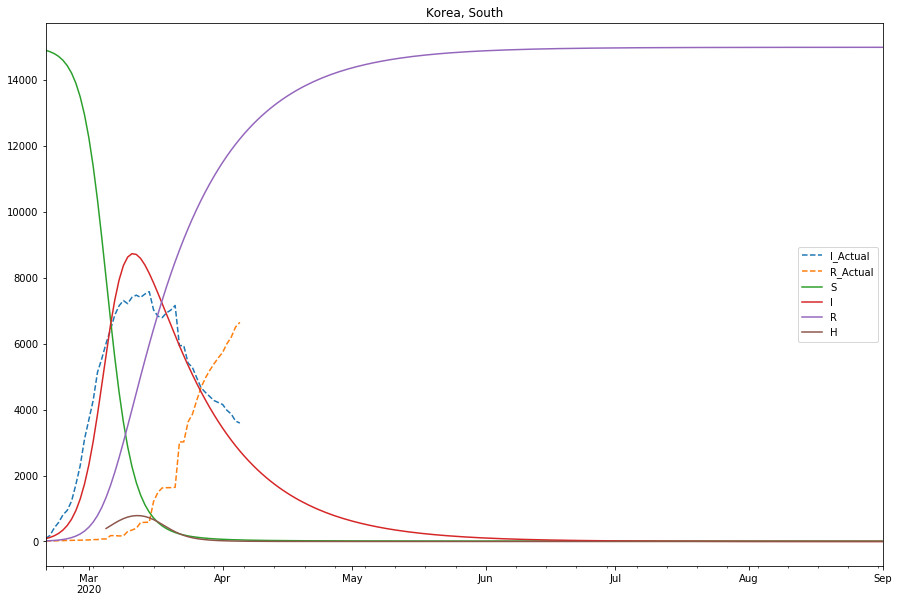

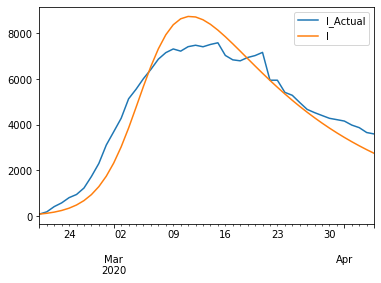

time: 872 ms


In [28]:
t1 = SIR('Korea, South', 
         N=15000, 
         #N=1e6,
         alpha=1,
         betaBounds = (0.1, 4.0),
         gammaBounds = (0.05, 2.0),
         nth = 100,
         hospRate = 0.07,
         daysToHosp = 1, #big for detction
         daysToLeave = 12,
         infectedAssumption = 1,
         #forcedBeta = 3,
         #quarantineDate = dt.datetime(2020,3,16), #italy lockdown was on the 9th
         #estimateBeta2 = True
                )

t1.train()

#italy_beta = t1.beta2
t1.main_plot()
t1.I_fit_plot()
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)
print('H Max:')
print(t1.df['H'].max())

How to estimate a trailing beta?

we could explain such a movement by decreasing the population
Maybe the only way to explain the movement is by a decaying beta, otherwise the shape of the curve maintains itself.

## Hospital Estimation based on Italy's beta

Our estimate of total infected. Based on US Influenza infected

In [29]:
fraction_pop = (9+45)/2/230
fraction_pop

0.11739130434782609

time: 3.76 ms


Now let's estimate Italy's beta after lockdown and its rolling beta estimation

Beta:0.29934517986373593 Beta2: 0.15276488689267811 Gamma:0.07
R0:4.276359712339084
Predicting with Beta:0.29934517986373593 Beta2: 0.15276488689267811 Gamma:0.07

Max:
3004211.2523706458
Est:
450631.6878555968
H Max:
189562.35301200958


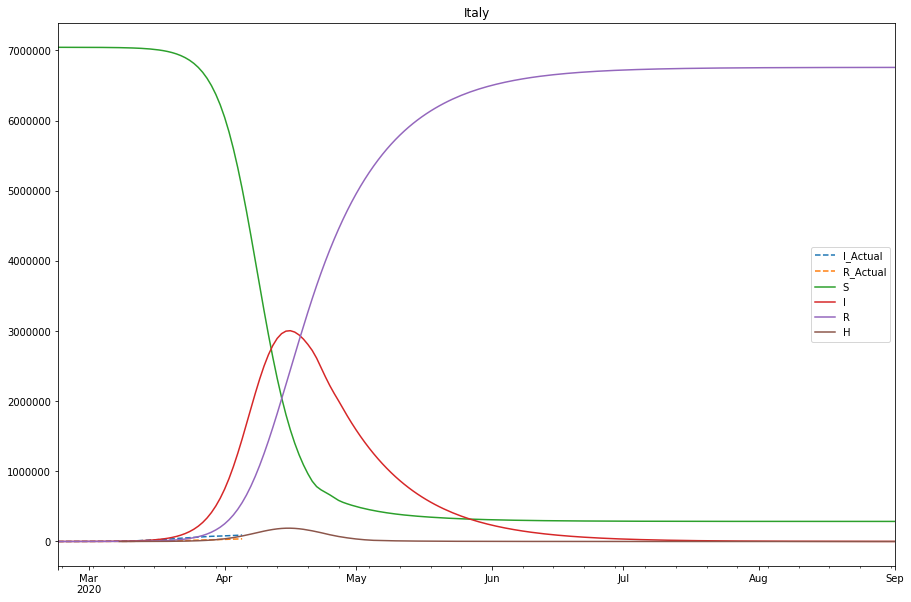

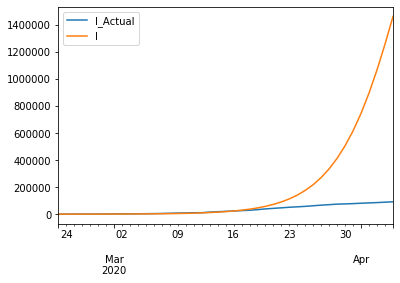

time: 3.03 s


In [35]:
t1 = SIR('Italy', 
         N=60e6 * fraction_pop, 
         #N=1e6,
         alpha=0.7,
         betaBounds = (0.1, 0.4),
         gammaBounds = (0.07, 0.1),
         nth = 100,
         hospRate = 0.05,
         daysToHosp = 1, #big for detction
         daysToLeave = 12,
         infectedAssumption = 1,
         quarantineDate = dt.datetime(2020,3,16), #italy lockdown was on the 9th
         estimateBeta2 = True
                )

t1.train()

italy_beta = t1.beta2
t1.main_plot()
t1.I_fit_plot()
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)
print('H Max:')
print(t1.df['H'].max())

In [36]:
italy_beta

0.15276488689267811

time: 4 ms


Beta:0.15276488689267811 Gamma:0.07
R0:2.1823555270382586
Predicting with Beta:0.15276488689267811 Beta2: 0.15276488689267811 Gamma:0.07

Max:
4337012.483499489
Est:
650551.8725249233
H Max:
211508.30057846225


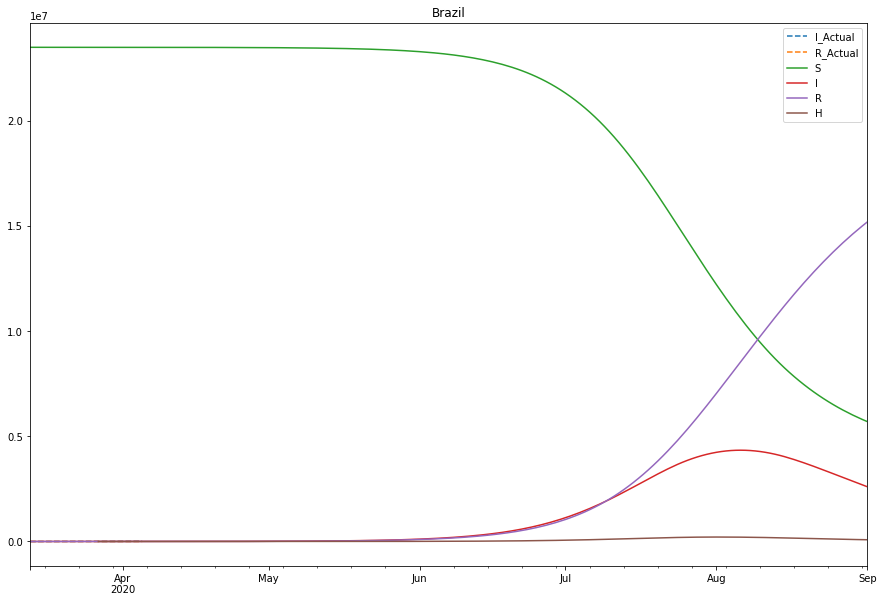

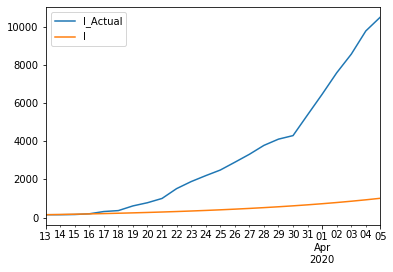

time: 515 ms


In [37]:
t1 = SIR('Brazil', 
         N=200e6 * (9+45)/2/230, 
         #N=1e6,
         alpha=0.7,
         betaBounds = (0.1, 0.4),
         gammaBounds = (0.07, 0.1),
         nth = 100,
         hospRate = 0.05,
         daysToHosp = 1, #big for detction
         daysToLeave = 12,
         infectedAssumption = 1,
         forcedBeta = italy_beta,
                )
#lockdown brazil 24/03
t1.train()
t1.main_plot()
t1.I_fit_plot()
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)
print('H Max:')
print(t1.df['H'].max())

Still to large. It seems we need a beta decay factor

# Beta decay

We will assueme the beta decays in time according to some funcion and try to estimate the decay factor using Korea's, Singapore's and other countries' data

## Increasing Window Beta

For exploration let's estimate beta everytime a new data comes around

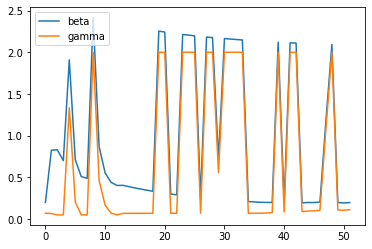

time: 15.4 s


In [6]:
t1 = SIR('Korea, South',
             N=51e6,
             # N=1e6,
             alpha=1,
             betaBounds=(0.1, 4.0),
             gammaBounds=(0.05, 2.0),
             nth=100,
             hospRate=0.07,
             daysToHosp=1,  # (after detection)
             daysToLeave=12,
             infectedAssumption=1,
             # forcedBeta = 3,
             # quarantineDate = dt.datetime(2020,3,16), #italy lockdown was on the 9th
             # estimateBeta2 = True
             )

ls = t1.rollingBetas()
t1.rollingList.plot()

It looks really unstable. Since we haven't yet implemented the decay factor, let's use a smaller population

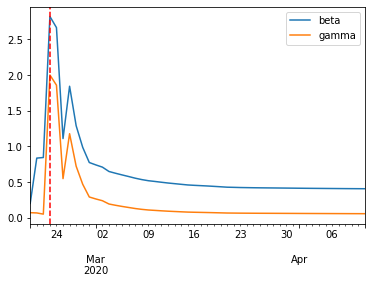

time: 11.4 s


In [2]:
t1 = SIR('Korea, South',
             N=15000,
             # N=1e6,
             alpha=1,
             betaBounds=(0.1, 4.0),
             gammaBounds=(0.05, 2.0),
             nth=100,
             hospRate=0.07,
             daysToHosp=1,  # (after detection)
             daysToLeave=12,
             infectedAssumption=1,
             # forcedBeta = 3,
             quarantineDate = dt.datetime(2020,2,23), #streets were empty
             # estimateBeta2 = True
             )

ls = t1.rollingBetas()
t1.rollingPlot()

In [3]:
t1.rollingList.iloc[-1]

beta     0.405718
gamma    0.055926
Name: 2020-04-11 00:00:00, dtype: float64

time: 3.99 ms


The dotted line show the quarentine date. Indeed it looks like the beta decays. It looks as if it works on the reduced population. We will try to stabilize the larger population with the decay

## Italy

Beta:0.40656744228578756 Gamma:0.21936060948737823
R0:1.8534204624790716
Predicting with Beta:0.40656744228578756 Beta2: 0.40656744228578756 Gamma:0.21936060948737823

Max:
102143.35720385931
Est:
15321.503580578896
H Max:
19246.034187829493


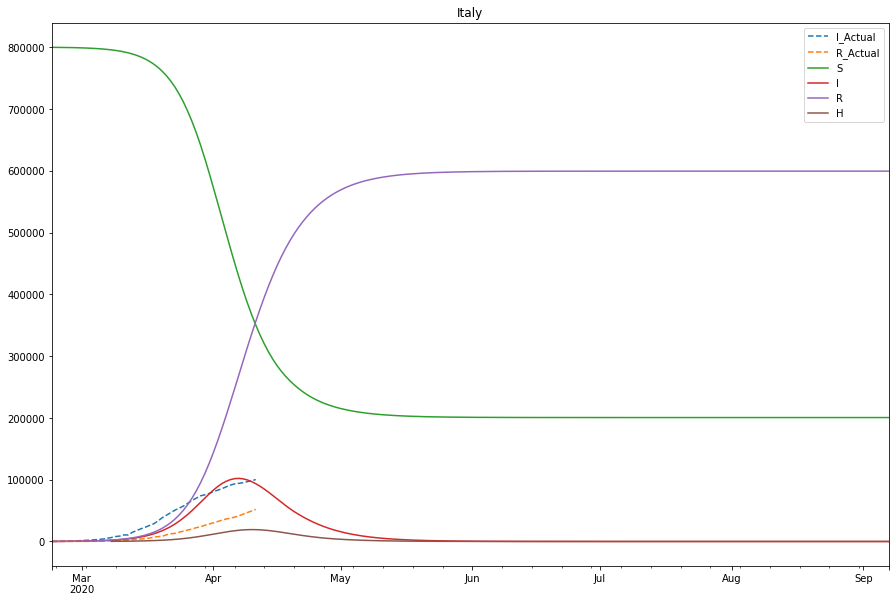

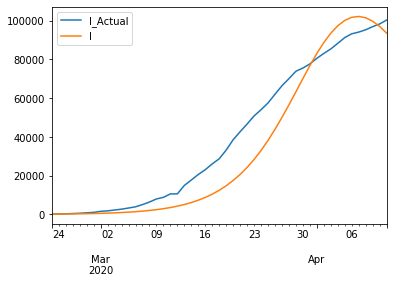

time: 983 ms


In [18]:
t1 = SIR('Italy', 
         N=.8e6, 
         #N=1e6,
         alpha=.9,
         betaBounds = (0.1, 4.0),
         gammaBounds = (0.05, 2.0),
         nth = 100,
         hospRate = 0.07,
         daysToHosp = 1, #big for detction
         daysToLeave = 12,
         infectedAssumption = 1,
         #forcedBeta = 3,
         #quarantineDate = dt.datetime(2020,3,16), #italy lockdown was on the 9th
         #estimateBeta2 = True
                )

t1.train()

#italy_beta = t1.beta2
t1.main_plot()
t1.I_fit_plot()
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)
print('H Max:')
print(t1.df['H'].max())


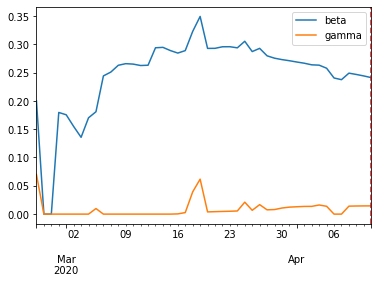

time: 13.3 s


In [17]:
t1.rollingBetas()
t1.rollingPlot()

## S0 estimation

Maybe we can constrain it to our 12% value and see what looks best. But then no decay is applicabble

Beta:0.6528352466139655 Gamma:0.028490145863238746 S_0:9863.02698590598
R0:22.914422753318664
Predicting with Beta:0.6528352466139655 Beta2: 0.6528352466139655 Gamma:0.028490145863238746

Max:
7517.778358444761
Est:
1127.666753766714
H Max:
572.9388039466884


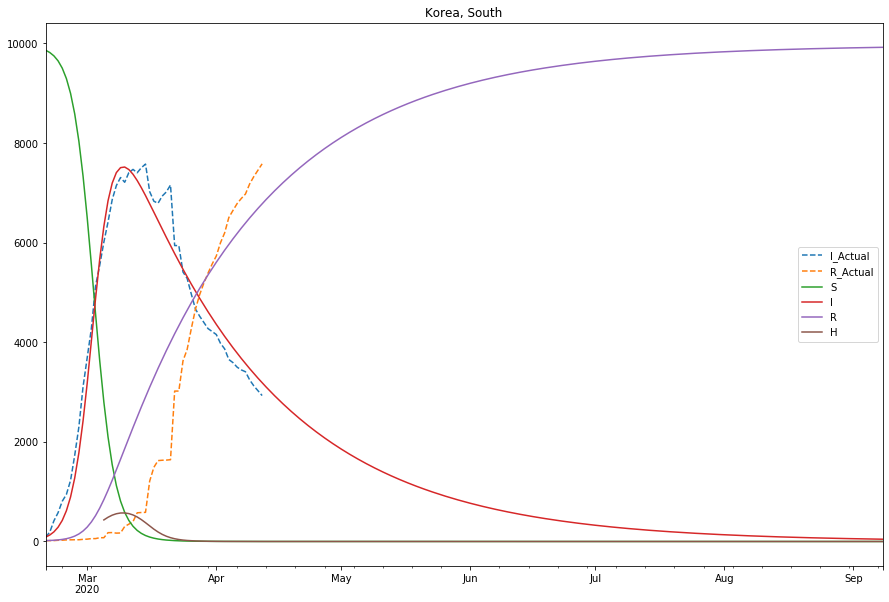

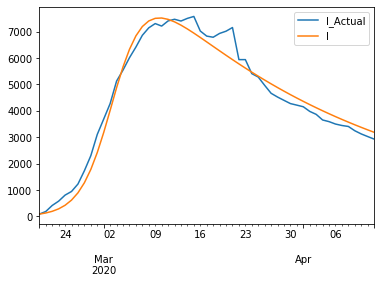

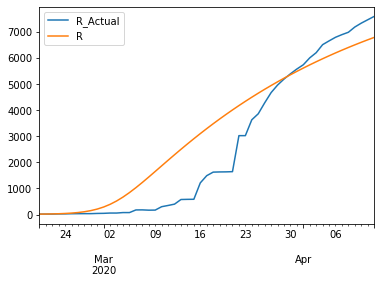

time: 2.26 s


In [19]:
t1 = SIR('Korea, South', 
         N=15000, 
         #N=1e6,
         alpha=0.8,
         betaBounds = (0.1, 4.0),
         gammaBounds = (0.01, 0.20),
         S0bounds = (5000, 50e6 * .12),
         nth = 100,
         hospRate = 0.07,
         daysToHosp = 1, #big for detction
         daysToLeave = 12,
         infectedAssumption = 1,
         #forcedBeta = 3,
         #quarantineDate = dt.datetime(2020,3,16), #italy lockdown was on the 9th
         #estimateBeta2 = True
         estimateS0 = True,
         R0bounds = None,
         
                )

t1.train()

#italy_beta = t1.beta2
t1.main_plot()
t1.I_fit_plot()
t1.R_fit_plot()
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)
print('H Max:')
print(t1.df['H'].max())

Beta:0.10000000000000504 Gamma:0.05000000000000791 S_0:2136159.448719982
R0:1.9999999999997844
Predicting with Beta:0.10000000000000504 Gamma:0.05000000000000791

Max:
909659.4819186266
Est:
136448.92228779398
H Max:
87040.39613139868


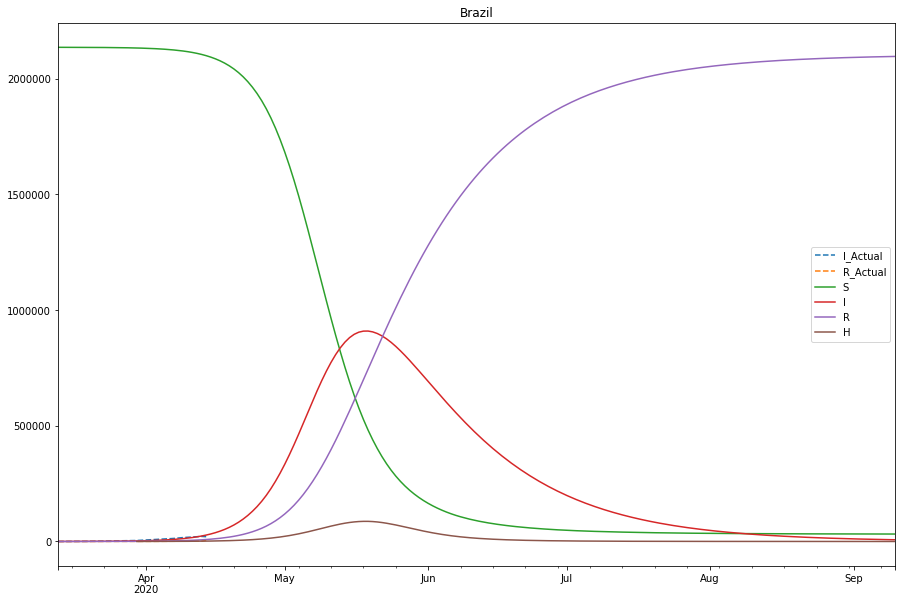

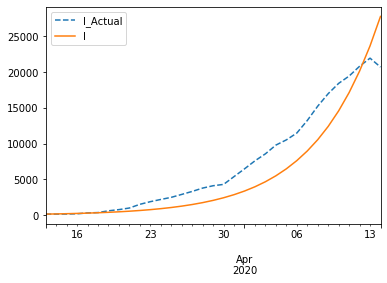

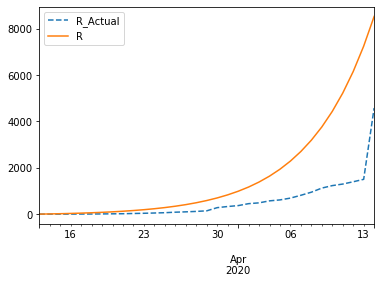

time: 1.46 s


In [2]:
t1 = SIR('Brazil', 
         N=1e6, 
         #N=1e6,
         alpha=.7,
         betaBounds = (0.1, 1.5),
         gammaBounds = (0.05, 2.0),
         S0bounds = (1e6, 200e6 * .12),
         nth = 100,
         hospRate = 0.10,
         daysToHosp = 4, #big for detction
         daysToLeave = 12,
         infectedAssumption = 1,
         #forcedBeta = 3,
         #quarantineDate = dt.datetime(2020,3,16), #italy lockdown was on the 9th
         #estimateBeta2 = True
         estimateS0 = True,
         #opt='SLSQP',
         R0bounds = (2.0,3.0),
         
                )

t1.train()

#italy_beta = t1.beta2
t1.main_plot()
t1.I_fit_plot()
t1.R_fit_plot()
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)
print('H Max:')
print(t1.df['H'].max())


In [3]:
t1.S_0

2136159.448719982

time: 2.99 ms


# Correcting the recovered curve

Clearly we have a problem concerning the recovered data, so we will interpolate it to fir a better looking one

Beta:0.22524512873414962 Gamma:0.07568729734112102 S_0:1000000.0003472817
R0:2.9759964570933835

Max:
298936.81008542294
Est:
44840.52151281344
H Max:
35206.039911096486


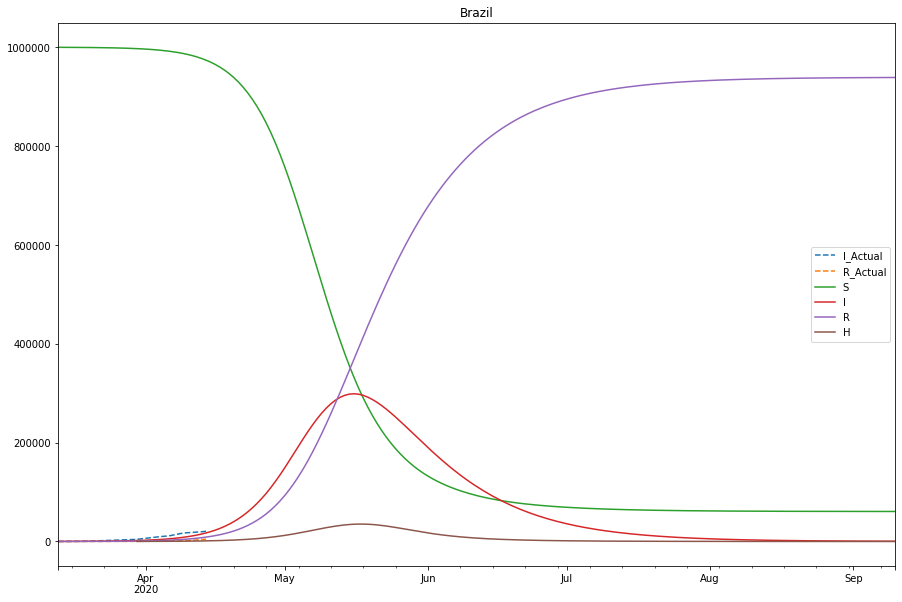

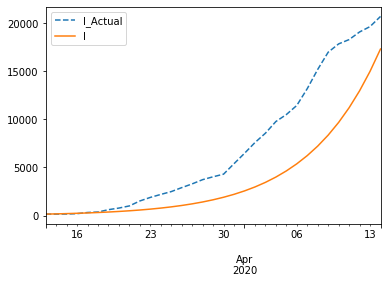

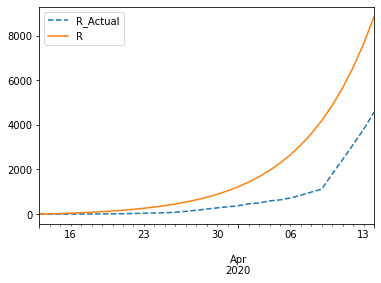

time: 812 ms


In [56]:
t1 = SIR('Brazil', 
         N=1e6, 
         #N=1e6,
         alpha=1,
         betaBounds = (0.1, 1.5),
         gammaBounds = (0.05, 2.0),
         S0bounds = (1e6, 200e6 * .12),
         nth = 100,
         hospRate = 0.10,
         daysToHosp = 4, #big for detction
         daysToLeave = 12,
         infectedAssumption = 1,
         #forcedBeta = 3,
         #quarantineDate = dt.datetime(2020,3,16), #italy lockdown was on the 9th
         #estimateBeta2 = True
         #opt='SLSQP',
         R0bounds = (2.0,3.0),
         adjust_recovered = True,
         
                )

t1.train()

#italy_beta = t1.beta2
t1.main_plot()
t1.I_fit_plot()
t1.R_fit_plot()
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)
print('H Max:')
print(t1.df['H'].max())


# Modelling Hospitalizations with a differential equation

Problem: the model is absolutely unstable

We aren't accounting for the fact that recovered people and people who leave the hospital must match

Thus we split the infected compartment into I (Infected and non hospital cases) and H (infected hospital cases).

Also we will split the deaths and recoveries data.

We adopt the simplification that all deaths come from hospital cases

If we find data on hospitalizations in brazil it should work even better

We added a few differential equations to account for the new compartments

$$\frac{dS}{dt} = - \frac{\beta IS}{N}$$

$$\frac{dI}{dt} = (1 - \rho) \times \frac{\beta IS}{N} - \gamma_{I} I$$

$$\frac{dH}{dt} = \rho \times \frac{\beta IS}{N} - (1-\delta) \times \gamma_{H} H - \delta \times \omega_{H} H$$


$$\frac{dR}{dt} = \gamma_{I} I + (1-\delta) \times \gamma_{H} H $$

$$\frac{dF}{dt} = \delta \times \omega_{H} H$$

Where

$$ I_{total} = I + H$$

Simplifications:
$$\beta_{I} = \beta_{H}$$

$$\gamma = \gamma_I + (1-\delta) \gamma_H + \delta \omega_H$$


**#TODO SE FICAR BOM FAZER O DIAGRAMA**

Beta:0.2951763041044909 Gamma:0.11017820903395989 S_0:1000000.000371212
Beta:0.2951763041044909 
Gamma:0.11017820903395989 
Gamma I:0.02857142857142857 
Gamma H:0.01785716067718583 
Omega:0.1999994645294188 
S0:1000000.000371212 
Delta:0.3499989757297887 
R0:2.679080615782288
(0.02857142857142857, 0.14285714285714285)
(0.017857142857142856, 0.14285714285714285)
(0.08333333333333333, 0.2)

Max:
627463.5131396723
Est:
94119.52697095084
H Max:
42427.59529833487
F Max:
85763.76501819558


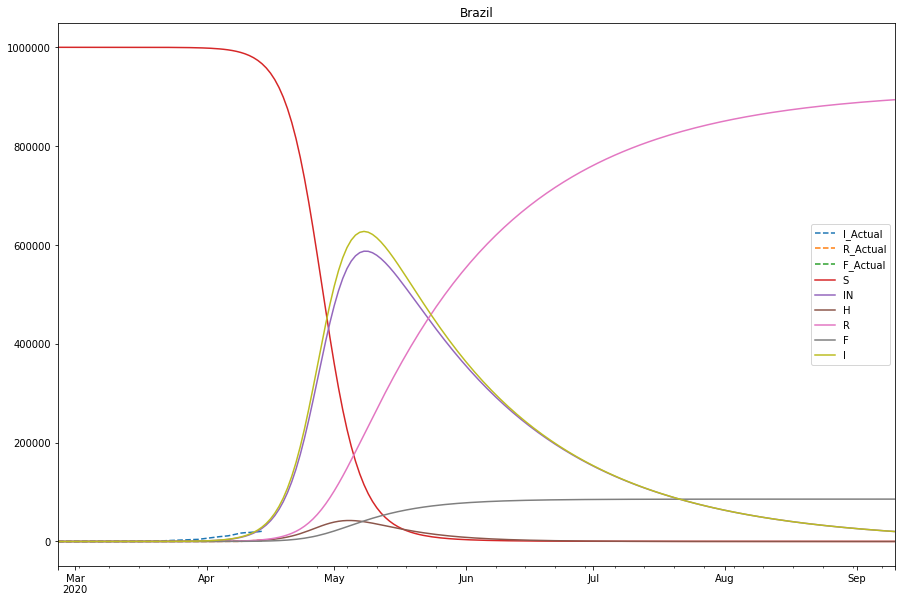

time: 744 ms


In [2]:
hospRate = 0.1
deltaUpperBound = 0.035 / hospRate

t1 = SIHRF(country = 'Brazil',
         N=1e6,
         # N=1e6,
         alpha=.7,
         betaBounds=(0.1, 1.5),
         gammaBounds=(0.05, 2.0),
         S0bounds=(.1e6, 200e6 * .12),
         nth=1,
         daysToHosp=4,  # big for detction
         daysToLeave=12,
         infectedAssumption=1,
         # forcedBeta = 3,
         quarantineDate = dt.datetime(2020,3,24), #italy lockdown was on the 9th
         # estimateBeta2 = True
         # opt='SLSQP',
         R0bounds=(0,20),
         hospRate=hospRate,
         delta_bounds=(0, deltaUpperBound),
         gamma_i_bounds=(1/(5*7), 1/(1*7)),
         gamma_h_bounds=(1/(8*7), 1/(1*7)),
         omega_bounds=(1/12, 1/5),
         #alphas=(0,0,1),
           adjust_recovered=True,
         )

t1.train()
t1.main_plot()
print(t1.gamma_i_bounds)
print(t1.gamma_h_bounds)
print(t1.omega_bounds)
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)
print('H Max:')
print(t1.df['H'].max())
print('F Max:')
print(t1.df['F'].max())

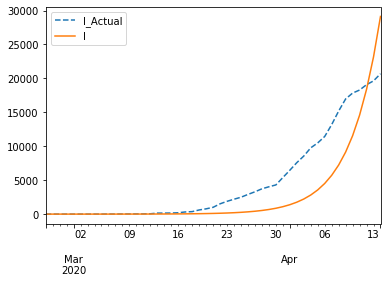

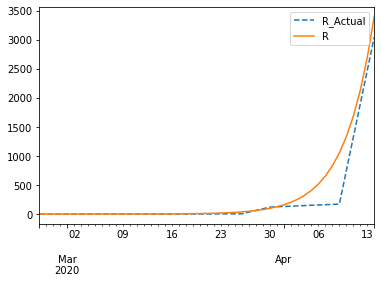

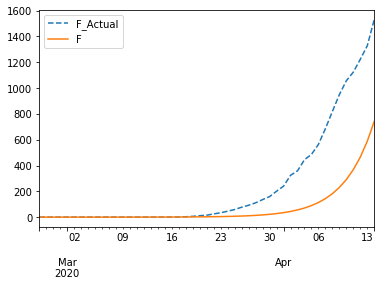

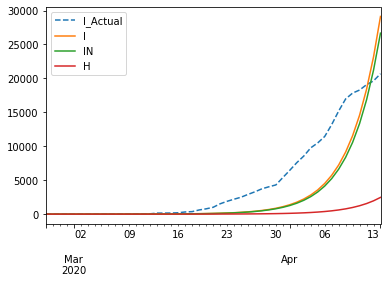

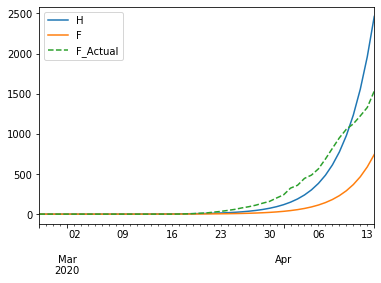

time: 1.18 s


In [3]:
t1.I_fit_plot()
t1.R_fit_plot()
t1.F_fit_plot()
t1.I_plot()
t1.H_F_plot()

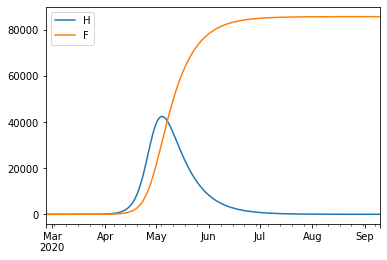

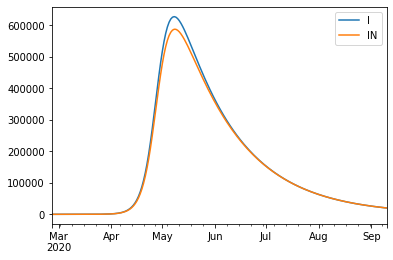

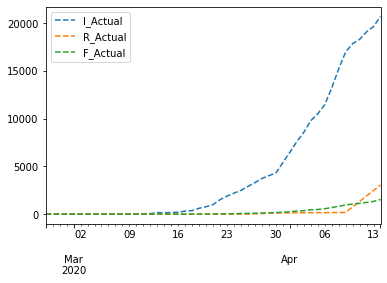

time: 810 ms


In [4]:
t1.df[['H', 'F']].plot()
t1.df[['I', 'IN']].plot()
t1.actuals_plot()

The approach is a lot more stable and seems to fit, but without a fastly decreasing beta it seems we wont be able to increase the population. Concerning stability, let's take a look at the hospital estimation over time

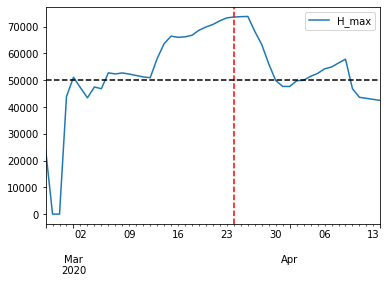

time: 21.7 s


In [5]:
df = t1.rollingHosp()
t1.rollingHospPlot()

# Sigmoid SIR

Both approaches (correcting recoveries and separating hospital and death cases) are quite unstable specially changing S0 (even though estimated)

So we will add time dynamics to beta according to a sigmoid function.

The larger motivator for such an approach is intuition

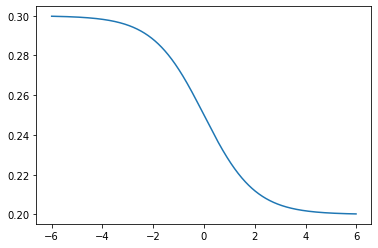

time: 121 ms


In [51]:
def sigmoid(x, beta1, beta2, lamb):
    return (beta1 - beta2) / (1 + np.exp(x/lamb)) + beta2

x = np.arange(-6,6,0.01)

beta1 = 0.3
beta2 = 0.2
lamb = 1
pd.Series(sigmoid(x, beta1, beta2, lamb),x).plot()

Beta1:0.17106555791543968 Beta2:0.10004628754622175 Lambda:0.27918492675663853 Gamma:0.06585824092920489 S_0:2000000.0
R0_initial:2.597481431356915
R0_quarentine:1.5191156966030677

Max:
613154.186255552
Est:
91973.1279383328
H Max:
64240.083585154374


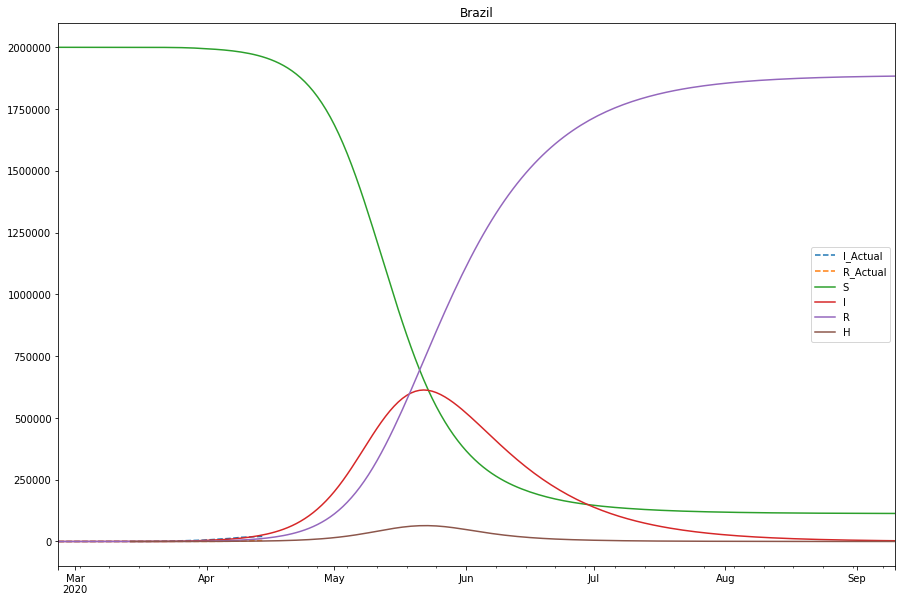

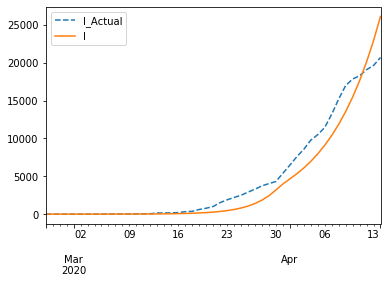

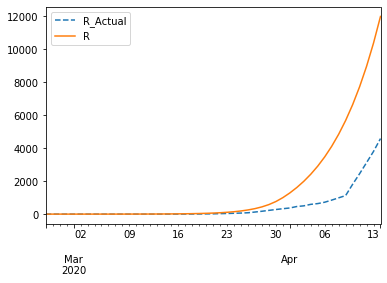

time: 1.3 s


In [32]:
S0 = 2e6 
t1 = SIR_sigmoid(country='Brazil', 
         N=1e6, 
         #N=1e6,
         alpha=0.85,
         betaBounds = (0.1, 1.5),
         gammaBounds = (0.001, .1),
         lambda_bounds=(.1,2),
         #S0bounds = (200e6 * .03, 200e6 * .12),
         S0bounds = (S0,S0),
         nth = 1,
         hospRate = 0.10,
         daysToHosp = 4, #big for detction
         daysToLeave = 12,
         infectedAssumption = 1,
         #forcedBeta = 3,
         quarantineDate = dt.datetime(2020,3,24), #italy lockdown was on the 9th, brazil 24-march
         #quarantineDate = dt.datetime(2020,4,1), #visual test
         #opt='SLSQP',
         R0bounds = (2.0,3.0),
         adjust_recovered = True,
         
                )

t1.train()

#italy_beta = t1.beta2
t1.main_plot()
t1.I_fit_plot()
t1.R_fit_plot()
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)
print('H Max:')
print(t1.df['H'].max())


# Exponential decaying beta

It still bothers that the model is unstable and that visually Brazil is already under-growing the curve.

Changing the time dynamics to exponential decay might (i) stabilize the model and (ii) fit the curve from Korea, even though so far brazil looks like it is just starting. To account for that we might need to add a plateau at the start

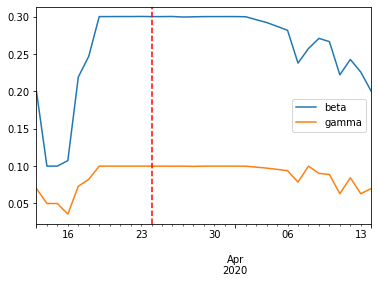

time: 2.95 s


In [41]:
S0 = 1e6 
t1 = SIR(country='Brazil', 
         N=1e6, 
         #N=1e6,
         alpha=0.85,
         betaBounds = (0.1, 1.5),
         gammaBounds = (0.001, .1),
         #S0bounds = (200e6 * .03, 200e6 * .12),
         S0bounds = (S0,S0),
         nth = 100,
         hospRate = 0.10,
         daysToHosp = 4, #big for detction
         daysToLeave = 12,
         infectedAssumption = 1,
         #forcedBeta = 3,
         quarantineDate = dt.datetime(2020,3,24), #italy lockdown was on the 9th, brazil 24-march
         #quarantineDate = dt.datetime(2020,4,1), #visual test
         #opt='SLSQP',
         R0bounds = (2.0,3.0),
         adjust_recovered = True,
         
                )

#t1.train()
#t1.main_plot()
#t1.I_fit_plot()
#t1.R_fit_plot()
ls = t1.rollingBetas()
t1.rollingPlot()

Next:
* Exponential decay beta
* rolling hosp estimation





* The prediction with two betas might be wrong. Maybe i need a new model when the beta is reset. Maybe the differential equation solver doesnt work on a multi-part. Or it might be just the prediction.
* observe rolling beta estimation
* calibrar com obeta 2 da italia considerando quarentena a partir de 15/mar. Ou seja: se a nossa quarentena tiver o efeito da itália, precisa ficar até quando? Quando tivermos novos dados desacelerando o brasil podemos usar nosso proprio novo beta.
* calibrar beta decay com a Coreia e usar metade

* ajustar infected assumption (nao ta incluindo os recuperados)
* conta de chegada - ver necessidade de hosp e qual seria o beta necessario


* SEIR parametros soltos
* fazer uma eq diferencial pro hosp
* pegar infos corretas de hospital
* O que eu acho do modelo de fato? Acho que o beta vai diminuir? Ou que existe um lag? Esse lag pode ser tratado no exposed?

Perguntas:
* Qual o fim da quarentena? Quantos casos sao internação (15% dos confirmados). Leitos na italia (12.5 * 60e6 / 1e5)
* Lag de tempo de internação (novo tratamento caindo de 15 p/ 7)
* Contrai, x (7) dias depois interna, y(10) dias depois sai da internação
* Novos dados | tirar nth day
* fazer brasil e coreia do norte
* fazer dados simulados

Outros:
* prob de contagio usando varios paises
* momento otimo de quarentena
* time varying beta


Dados hospitalizacao
https://www.medrxiv.org/content/10.1101/2020.03.30.20047662v1

US 45 MM influenza
https://www.cdc.gov/flu/about/burden/index.html


BR 65k respiradores e 55k leitos
https://exame.abril.com.br/brasil/ampliar-leitos-de-uti-e-meta-do-ministerio/
Usam 10% da populacao infectada
Usual hosp: time to hosp 3-7 days ; length 7-15 
ICU hosp: 8-15 and 7-15

Dobro de pessoas contagiadas
https://www.economist.com/science-and-technology/2020/04/02/an-antibody-test-for-the-novel-coronavirus-will-soon-be-available
Lembrar de derrubar taxas de demanda pela metade

5% need ICU - half those need ventilation for 5 days


Alternative scenario (italy) 12% need ICU


Unreported cases
https://www.medrxiv.org/content/10.1101/2020.03.14.20036178v2

Recovery time for hosp and non hosp
Using available preliminary data, the median time from onset to clinical recovery for mild cases is approximately 2 weeks and is 3-6 weeks for patients with severe or critical disease
https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf